# About Q-Learning algorithm
> "Q-learning is a model-free reinforcement learning algorithm. The goal of Q-learning is to learn a policy, which tells an agent what action to take under what circumstances. It does not require a model (hence the connotation "model-free") of the environment, and it can handle problems with stochastic transitions and rewards, without requiring adaptations."
[*wiki*](https://en.wikipedia.org/wiki/Q-learning)

In [ ]:
!pip install keras
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib as mpl
import joblib
import os
import keras

import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [ ]:
import gym
gym.envs.registry.all()

#### DQN부터 시작

In [210]:
# 데이터셋 = cartpole
!pip install numpy==1.19.5
keras.backend.clear_session()
env = gym.make("CartPole-v1")
input_shape = [4]
n_outputs = 2

In [211]:
env.observation_space.shape

(4,)

In [212]:
# 모델 정의
# 레이어 2층, 아웃풋 1층
model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [213]:
# 입실론 그리디 정책
# 최초 입실론 0
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [214]:
# replay 메모리
from collections import deque

replay_memory = deque(maxlen=2000)

In [215]:
# 경험 샘플링 함수 정의
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [216]:
# 한 step 이동하는 함수 정의
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [217]:
# 모델 정의
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

In [220]:
# DQN 학습 전체 정의
# 입실론, 그리디 policy, q-벨류 알고리즘, 자동미분 사용
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = np.array(actions)
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_weights)
#     optimizer.apply_gradients(zip(grads, model.trainable_weights))

In [221]:
# 모델 학습
env.seed(1)
tf.random.set_seed(1)
rewards=[]
best_score=0
# observe 초기화부터 시작. 600회
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step >= best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

Episode: 599, Steps: 200, eps: 0.010

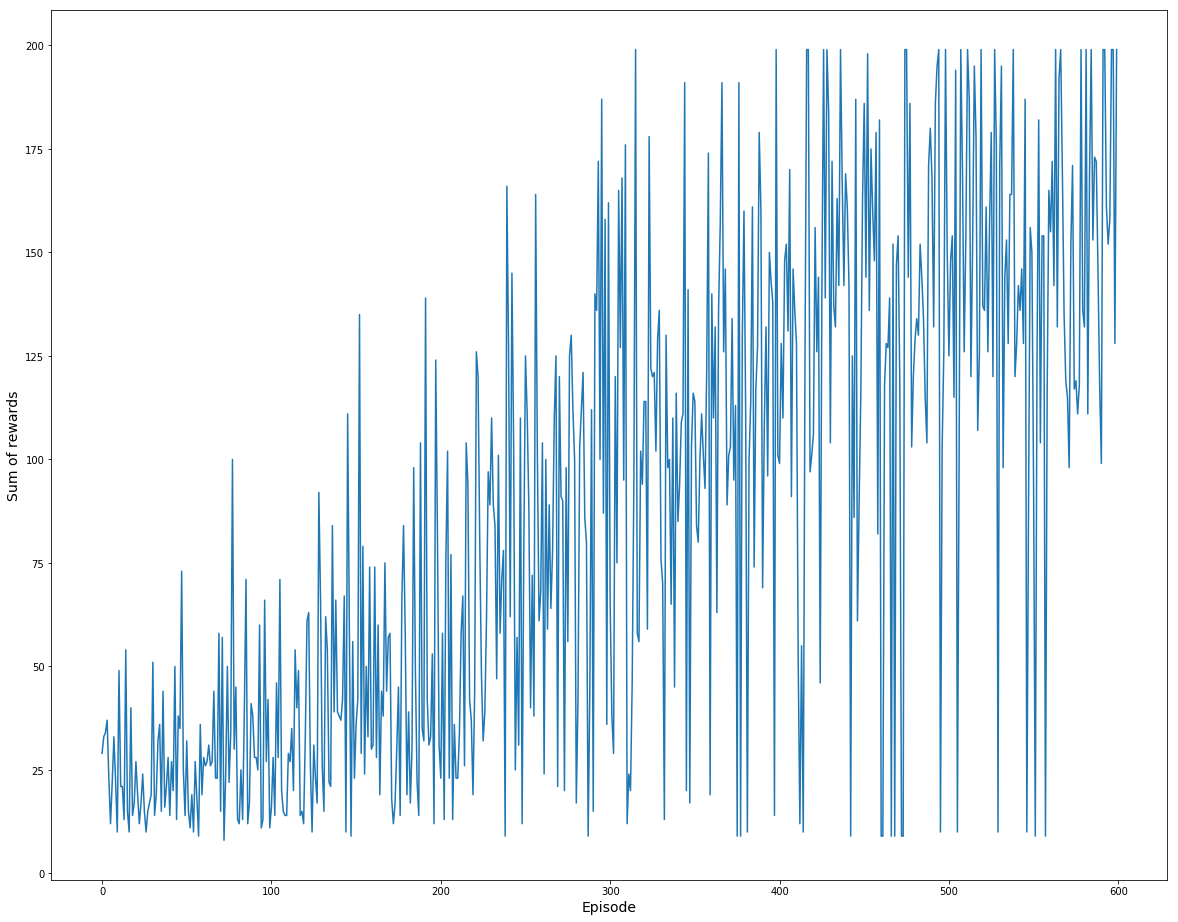

In [225]:
# 에피소드 반복에 따른 시각화
plt.figure(figsize=(20, 16))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [255]:
!pip install pyvirtualdisplay
# 파이썬 화면 가상환경
import pyvirtualdisplay


In [250]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900, 24)).start()
except ImportError:
    pass

In [256]:
env.render()

ImportError: 
    Error occurred while running `from pyglet.gl import *`
    HINT: make sure you have OpenGL install. On Ubuntu, you can run 'apt-get install python-opengl'.
    If you're running on a server, you may need a virtual frame buffer; something like this should work:
    'xvfb-run -s "-screen 0 1400x900x24" python <your_script.py>'
    

In [ ]:
frames=[]
obs = env.reset()
for step in range(200):
  img = env.render(mode="rgb_array")
  frames.append(img)
  action = basic_policy(obs)

  obs, reward, done, info = env.step(action)
  if done:
    break
def update_scene(num, frames, patch):
  patch.set_data(frames[num])
  return patch,

def plot_animation(frames, repeat = False, interval=40):
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = animation.FuncAnimation(
      fig, update_scene, fargs=(frames, patch),
      frames = len(frames), repeat=repeat, interval = interval
  )
  plt.close()
  return anim

In [ ]:
# DQN 애니메이션 반출
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

#### Double DQN